---
## Traffic sign classifier using Convolutional Neural Network

this is a framework which can be used to classify images . in this program i had classified the german trafic sign images . using my model , i was able to classify some random images which i downloaded from online 

### loading datas
load the training , validation , and testing data to work with your model

###### please specify the correct file path in the training_file ,validation_file and testing_file


In [1]:
import random
import cv2
import pickle
import tensorflow as tf
import csv
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import random
from tensorflow.contrib.layers import flatten
%matplotlib inline


In [2]:


training_file ='D:\\tutorials\\nanodegree\\SDC\\unit_6_Traffic_sign_classifier\\CarND-Traffic-Sign-Classifier-Project\\train.p' 
validation_file='D:\\tutorials\\nanodegree\\SDC\\unit_6_Traffic_sign_classifier\\CarND-Traffic-Sign-Classifier-Project\\valid.p'
testing_file = 'D:\\tutorials\\nanodegree\\SDC\\unit_6_Traffic_sign_classifier\\CarND-Traffic-Sign-Classifier-Project\\test.p'


with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### sign name 
the labels in the training data uses specific numbers to identify different signs . the filesignnames.csv has the number mapped for the sign type . this code  block is goingto create a dictionary of numbers to the sign type . this will come in handy when we classify our own images taken from internet

In [4]:
# create a dictionary with class number and sign name pair

signValues = {}
with open('signnames.csv',newline='') as file :
    read = csv.reader(file,delimiter = ',', quotechar='|')
    for row in read:
        if row[0] != 'ClassId':
            signValues[int(row[0])] = row[1]

In [3]:
BATCH_SIZE = 256

### summery of our data

In [5]:


n_train = X_train.shape[:][0]


n_test =  y_test.shape[:][0]


image_shape = X_train[0].shape

n_classes = np.max(y_train)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 42


### Distribution of data set

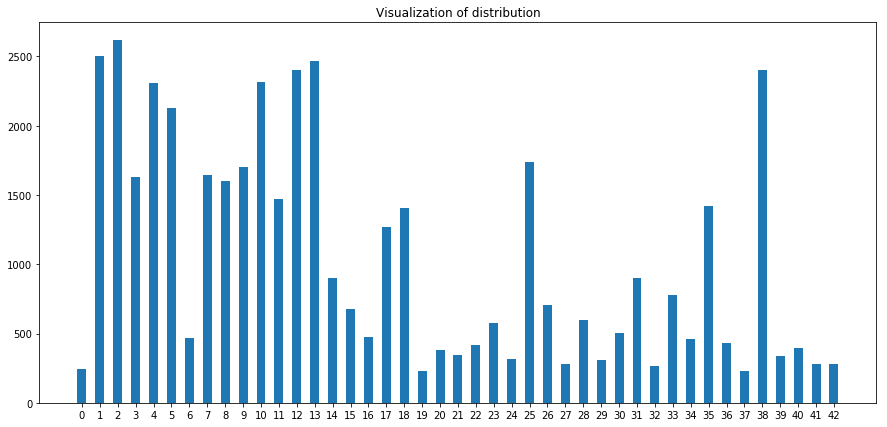

In [12]:
label , num = np.unique (y_train , return_counts = True)# return two list of unique label and their count 

plt.rcParams["figure.figsize"] = [15,7]
plt.bar(label, num, tick_label=label, width=0.5, align='center')
plt.title('Visualization of distribution')

### preprocess and augment the training data

our training data is made up of 32X3X3 (BGR) . training on this data is one way of approach
but , the number of training data provided is much less . i am going to augment the data by adding slight transformation to the images by a pixel of (0,5) range . this will produce 10,000 image addition to hte traininig data provided and this will help in overcoming the problem of overfitting 

In [8]:


k = []
l = []
# width and height of the imput image 
width = X_train.shape[1] 
col = X_train.shape[2]

for i in range(X_train.shape[:][0]):
    k.append(X_train[i]) #reshaping temp image of size 32X32 to 32X32X1
    l.append(y_train[i])

# create 10000 additional training data by transforming training  data  
v = 0

while v < 10000:
    v+=1
        
    
    rand = random.randint(0,X_train.shape[0]-1) # generate a random varable to choose an image 
    img = X_train[rand]
    w,h = random.randint(0,5),random.randint(0,5)# generate a random varable to shift the image by pixels
    M = np.float32([[1,0,w],[0,1,h]])
        
    opt = cv2.warpAffine(img,M,(col,width))
    k.append(opt)
    l.append(y_train[rand]) # grab and add the training label for the specific trafic sign

  
    
X_train = np.array(k)
y_train = np.array(l)
print (X_train.shape)


(44799, 32, 32, 3)


### shuffling of data

In [9]:

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)
X_valid, y_valid = shuffle(X_valid, y_valid)

### visualization of the Training Image

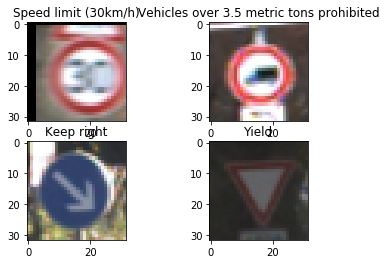

In [10]:



%matplotlib inline




#plt.set_window_title('hi')
_,a = plt.subplots(2,2)

for i in range(0,2):
    for j in range(0,2):
        
        w = random.randint(0,X_train.shape[0])
        a[i][j].imshow( X_train[w].squeeze())
        a[i][j].set_title(signValues[y_train[w]])
        
plt.show()




### Model Architecture

### function to create convolution layer 

conv2d ( input (Tf placeholder) , filter (Weights) , stride size , padding ('VALID','SAME') , biase  )

this function takes input (tf constant , image , convolute layer ) , weights , and biase , create convolute layer
using provided weight , adds biases to it and applies relu 

In [6]:
def conv2d(input,filter,strides,padding,biase):
    #creation of a convolution layer
    convLayer = tf.nn.conv2d(input,filter,strides,padding)
    convLayer = tf.nn.bias_add(convLayer,biase)
    convLayer = tf.nn.relu(convLayer)
    return convLayer

### function to apply pooling to the convolute layer 

pooling ( input (convolute layer) , ksize (window ) , stride , padding('VOID ' , 'SAME))

In [7]:
def pooling(input , ksize , strides , padding):
    maxPool = tf.nn.max_pool(input , ksize , strides , padding)# applying max pooling to the convolute lyer
    return maxPool
    

In [8]:
# definition of mean and standerd deviation for truncated normal
mu = 0
sigma = 0.01

### Define placeholder

In [9]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))# image placeholder for grayscale image with dimention (None ,32,32,1)
y = tf.placeholder(tf.int32, (None))# image label placeholder
one_hot_y = tf.one_hot(y, 42)# label converted to oh hot encoding for easy classification by neurons in output layer
dropout = tf.placeholder(tf.float32,(None))# dropout place holder ( 0.0 - 1.0)

### Weights and Biase variable definition 

#### for convolution layer

In [10]:
# definition of weights 
weights2 = {'wc1':tf.Variable(tf.truncated_normal([3,3,3,16],mean = mu , stddev = sigma)),# [height , width , ip_dimention , op_dimention]
           'wc2':tf.Variable(tf.truncated_normal([5,5,16,64],mean = mu , stddev = sigma)),
           'wc3':tf.Variable(tf.truncated_normal([3,3,64,128],mean = mu , stddev = sigma)),
           'wc4':tf.Variable(tf.truncated_normal([3,3,128,64],mean = mu , stddev = sigma))}
biases2  = {'bc1':tf.Variable(tf.truncated_normal([16],mean = mu , stddev = sigma)),
           'bc2':tf.Variable(tf.truncated_normal([64],mean = mu , stddev = sigma)),
           'bc3':tf.Variable(tf.truncated_normal([128],mean = mu , stddev = sigma)),
           'bc4':tf.Variable(tf.truncated_normal([64],mean = mu , stddev = sigma))}

#### for fully connected layer

In [11]:
# defining weights and biases for fully connected layer
weightFullyConnected2 = {'wf1':tf.Variable(tf.truncated_normal([2304,1024],mean = mu , stddev = sigma)),
                        'wf2':tf.Variable(tf.truncated_normal([1024,1024],mean = mu , stddev = sigma)),
                        'out':tf.Variable(tf.truncated_normal([1024,42],mean = mu , stddev = sigma))}
biasesFullyConnected2 = {'bf1':tf.Variable(tf.truncated_normal([1024],mean = mu , stddev = sigma)),#120 - 320
                        'bf2':tf.Variable(tf.truncated_normal([1024],mean = mu , stddev = sigma)),
                        'out':tf.Variable(tf.truncated_normal([42],mean = mu , stddev = sigma))}

### Graph definition 

In [12]:

def graph1(x):
    
    layer1 = conv2d(x,weights2['wc1'],[1,1,1,1],'SAME',biases2['bc1'])
    layer1 = pooling(layer1,[1,3,3,1],[1,1,1,1],'SAME')# C

    layer2 = conv2d(layer1,weights2['wc2'],[1,3,3,1],'VALID',biases2['bc2'])

    layer2 = pooling(layer2,[1,3,3,1],[1,1,1,1],'VALID')# C

    layer3 = conv2d(layer2,weights2['wc3'],[1,1,1,1],'SAME',biases2['bc3'])

    layer4 = conv2d(layer3,weights2['wc4'],[1,1,1,1],'SAME',biases2['bc4'])

    layer4 = pooling(layer4,[1,3,3,1],[1,1,1,1],'VALID') # c


    # adding flatten to 
    flatInput = flatten(layer4)

    fc1 = tf.add(tf.matmul(flatInput,weightFullyConnected2['wf1']),biasesFullyConnected2['bf1'])
    fc1 = tf.nn.dropout(fc1,dropout)

    fc2 = tf.add(tf.matmul(fc1,weightFullyConnected2['wf2']),biasesFullyConnected2['bf2'])
    fc2 = tf.nn.dropout(fc2,dropout)

    out = tf.add(tf.matmul(fc2,weightFullyConnected2['out']),biasesFullyConnected2['out'])
    return out


### To visualize the model
To visualize the features of eaxh layers , we have to pass the data through the seperately . defining them here will
help us to vizualize those features (to see visualization , go down )

In [13]:
layer1 = conv2d(x,weights2['wc1'],[1,1,1,1],'SAME',biases2['bc1'])
layer1pooling = pooling(layer1,[1,3,3,1],[1,1,1,1],'SAME')# C

layer2 = conv2d(layer1,weights2['wc2'],[1,3,3,1],'VALID',biases2['bc2'])

layer2pooling = pooling(layer2,[1,3,3,1],[1,1,1,1],'VALID')# C

layer3 = conv2d(layer2,weights2['wc3'],[1,1,1,1],'SAME',biases2['bc3'])

layer4 = conv2d(layer3,weights2['wc4'],[1,1,1,1],'SAME',biases2['bc4'])

layer4pooling = pooling(layer4,[1,3,3,1],[1,1,1,1],'VALID') # c


### Initialization of methods 

In [14]:
rate = 0.0004#5e-3#0.005

logits = graph1(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)#one_hot_y :y
just_soft_max = tf.nn.softmax(logits)
loss_operation = tf.reduce_mean(cross_entropy)
#optimizer = tf.train.AdamOptimizer(learning_rate = rate)
optimizer = tf.train.RMSPropOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))#one_hot_y :y
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
predictions = tf.argmax(logits, 1)
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,dropout : 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### create a file named model on the working directory so that you will have a seperate place to store your model for furthur usage 

In [19]:
model = 'D:\\tutorials\\nanodegree\\SDC\\projectsUploaded\\3_trafic_signal\\model\\data.ckpt'

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [20]:
EPOCHS=9

In [ ]:
from sklearn.utils import shuffle
import time
start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
        
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,dropout:0.1})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print ('time for epoch {} is {}'.format(i,start_time - time.time()))
        print()
        
    #saver.save(sess, model)
    #saver.save(sess, './lenet')
    saver.save(sess, model)
    print("Model saved")
    print ('total time {}'.format(time.time()-start_time))
    
    
    

Training...

EPOCH 1 ...
Validation Accuracy = 0.054
time for epoch 0 is -395.7584273815155



### Testing your model

In [21]:
with tf.Session() as sess:
    saver.restore(sess, model)
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    testAccuracy = evaluate(X_test,y_test)
    trainAccuracy = evaluate(X_train,y_train)
    print ('the test accuracy of this model : {}'.format(testAccuracy))
    print ('the train accuracy of this model : {}'.format(trainAccuracy))

NotFoundError: NewRandomAccessFile failed to Create/Open: D:\tutorials\nanodegree\SDC\projectsUploaded\3_trafic_signal\model\data.ckpt.data-00000-of-00001 : The system cannot find the file specified.

	 [[Node: save/RestoreV2_41 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_41/tensor_names, save/RestoreV2_41/shape_and_slices)]]

Caused by op 'save/RestoreV2_41', defined at:
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-2371ba981fa3>", line 4, in <module>
    saver = tf.train.Saver()
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\training\saver.py", line 1051, in __init__
    self.build()
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\training\saver.py", line 1081, in build
    restore_sequentially=self._restore_sequentially)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\training\saver.py", line 675, in build
    restore_sequentially, reshape)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\training\saver.py", line 402, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\training\saver.py", line 242, in restore_op
    [spec.tensor.dtype])[0])
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 668, in restore_v2
    dtypes=dtypes, name=name)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\yuvaram\Miniconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): NewRandomAccessFile failed to Create/Open: D:\tutorials\nanodegree\SDC\projectsUploaded\3_trafic_signal\model\data.ckpt.data-00000-of-00001 : The system cannot find the file specified.

	 [[Node: save/RestoreV2_41 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_41/tensor_names, save/RestoreV2_41/shape_and_slices)]]


### Load New Image 

this code block loads new image downloaded from online , reshapes them into 32X32X3 , converts it to grayscape and applies normalization , and add it to X_out with shape (None , 32 , 32 , 1)

In [146]:
outTest = []
        
### use the appropriate Directory path based on yur os ( windows , mac , linux) each has a different type of file path 
### i am currently using Linux ( from Floydhub website )
img1 ='./testPic/a.jpg'
img2 ='./testPic/b.jpg'
img3 ='./testPic/c.jpg'
img4 ='./testPic/d.jpg'
img5 ='./testPic/e.jpg'

test1=cv2.resize(cv2.imread(img1,1),(32,32),interpolation = cv2.INTER_AREA)
test2=cv2.resize(cv2.imread(img2,1),(32,32),interpolation = cv2.INTER_AREA)
test3=cv2.resize(cv2.imread(img3,1),(32,32),interpolation = cv2.INTER_AREA)
test4=cv2.resize(cv2.imread(img4,1),(32,32),interpolation = cv2.INTER_AREA)
test5=cv2.resize(cv2.imread(img5,1),(32,32),interpolation = cv2.INTER_AREA)
outTest.append(test1)
outTest.append(test2)
outTest.append(test3)
outTest.append(test4)
outTest.append(test5)
X_out = np.array(outTest)
print (X_out.shape)


(5, 32, 32, 3)


### Predict the Sign Type for Each Image 

In [147]:

with tf.Session() as sess:
    saver.restore(sess, model)
    #saver.restore(sess, tf.train.latest_checkpoint('.'))

    pri = sess.run(predictions,feed_dict={x:X_out,dropout:1.0}) # predict the label for these images . use 1.0 for dropout value

predictedSign = [signValues[x] for x in pri]
print (predictedSign)

['Speed limit (20km/h)', 'Speed limit (60km/h)', 'Children crossing', 'Wild animals crossing', 'No entry']


### Analyze Performance

In [149]:
hand_coded_labels = [0,3,28,31,33] # hand code the sign h=number using the signname.csv file provided 
count = 0
for i in range(len(pri)):
    if pri[i]== hand_coded_labels[i]: # check with the predicted result
      count+=1
percentage = (100/len(pri))*count # calculate the accuracy of your prediction 
print ('This is the percentage of accuracy for this test model {}%'.format(percentage))

This is the percentage of accuracy for this test model 80.0%


### Display the top softmax predictions for our own image 

In [151]:
# printing the top 3 softmax prediction on the image taken from online
with tf.Session() as sess:
    saver.restore(sess, model)
    #saver.restore(sess, tf.train.latest_checkpoint('.'))

    softmaxValue = sess.run(tf.nn.top_k(just_soft_max,k=3),feed_dict={x:X_out,dropout:1.0})
   

index = softmaxValue[1]
softmax = softmaxValue[0]
for i in range (len(index)) :
    print_index = index[i]
    print_soft = softmax[i]
    value = ''
    for j in range(len(print_index)):
        value += signValues[print_index[j]]
        value += ' = '+str(print_soft[j]) 
        value +='\n'
    print (value)
 

Speed limit (20km/h) = 0.99399
Speed limit (60km/h) = 0.00599556
End of speed limit (80km/h) = 1.40893e-05

Speed limit (60km/h) = 0.999861
Children crossing = 0.000129891
Speed limit (20km/h) = 8.8125e-06

Children crossing = 0.999998
Speed limit (100km/h) = 1.5903e-06
Bicycles crossing = 3.31714e-09

Wild animals crossing = 0.998607
Double curve = 0.00136221
Dangerous curve to the left = 2.22656e-05

No entry = 0.889737
Speed limit (100km/h) = 0.108129
Stop = 0.00211483



---

##  Visualization of  the Neural Network's State with Test Images

 


In [152]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input,dropout:1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

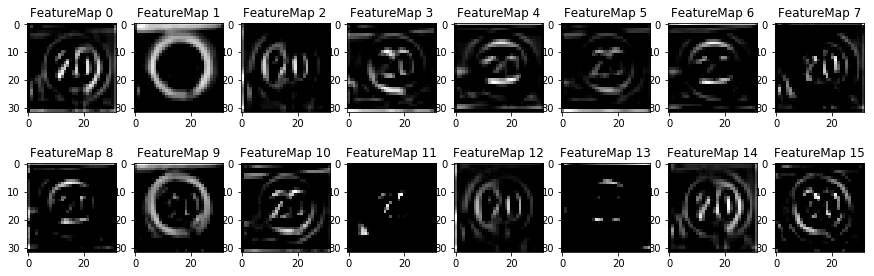

In [155]:
### to visualize the feature map 
with tf.Session() as sess:
    #saver.restore(sess, model)
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    outputFeatureMap(X_out[0:1], layer1 , activation_min=-1, activation_max=-1 ,plt_num=1)
    

### use of visualizing feature map 

visualization of feature map , clearly shows us the type of features which causes activation on our convalution layer 

the lighter pixels in the images , shows the  feature which causes activation , where the darker pixels represent no 
activation 

comparing these images with the original image , shows us a clear understanding of what casing activation 